In [1]:
import json
import os
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [2]:
"Number of eaf/annotation files: %d"%(len(os.listdir("json_data/")))

'Number of eaf/annotation files: 28'

In [3]:
## Annotation types
sample_file = json.load(open("json_data/bild-covid0103-jh.json", "r")) ## Sample BildTV file
print("\n".join(key for key in sample_file))

default
faces
asr-de: korona
captions: talking
captions: walking
captions: holding
Freiheit
uncertainty/blaming
fight/conflict
shots
places 365
shot size
analytical
trust
emotion
music-noise
speaker-gender


In [4]:
bild_files = [fname for fname in os.listdir("json_data/") if 'bild' in fname]
com_files = [fname for fname in os.listdir("json_data/") if 'com' in fname]
tag_files = [fname for fname in os.listdir("json_data/") if 'tag' in fname]

print("#Bild files: %d"%(len(bild_files)))
print("#Com files: %d"%(len(com_files)))
print("#Tag files: %d"%(len(tag_files)))

## Labels of interest
labels = ["faces", "Freiheit", "uncertainty/blaming", "fight/conflict", 
            "shot size", "places 365", "trust", "emotion", "music-noise",
             "speaker-gender", "analytical", "captions: talking", "captions: walking", "captions: holding"]

#Bild files: 10
#Com files: 9
#Tag files: 9


In [11]:
def get_overlap(start1, end1, start2, end2):
    return max(0, min(end1, end2) - max(start1, start2))/(end2-start2)

## Filter segments which have an 80% overlap with corona segments
def filter_for_topic(files, overlap=0.8):
    file_annots = {}
    for annfile in files:
        annot = json.load(open("json_data/"+annfile,"r"))
        if "asr-de: korona" in annot:
            topic_times = annot["asr-de: korona"]["segments"]
            topic_duration = 0 
            for topic_seg in topic_times:               ## Get total covid duration per video
                topic_duration += (topic_seg["end"]-topic_seg["start"])
            
            annot["corona_duration"] = topic_duration

            for lab in labels:
                new_lab_segments = []
                lab_segment = annot[lab]["segments"] if lab in annot else []
                for segment in lab_segment:
                    for topic_seg in topic_times:
                        ovp = get_overlap(topic_seg["start"], topic_seg["end"], segment["start"], segment["end"])
                        if ovp >= overlap:
                            new_lab_segments.append(segment)
                            break
                if lab in annot:
                    annot[lab]["segments"] = new_lab_segments
        
            file_annots[annfile] = annot
    
    return file_annots


def get_distribution_for_annot_type(files_annot, atype):
    annot_label_count = {}
    file_cnt = 0
    for annfile in files_annot:
        annot = files_annot[annfile]
        
        if atype in annot:
            # check if annot["faces"]["segments"] is empty for specific file tag-covid-0102-jh.eaf
            annot_segs = annot[atype]["segments"]
        
            for part in annot_segs:
                if part["label"] is not None and len(part["label"].strip('"')) > 0:
                    label = part["label"].strip('"').strip(" ").replace('"','')
                    if label.lower() not in annot_label_count:
                        annot_label_count[label.lower()] = 1
                    else:
                        annot_label_count[label.lower()] += 1
            
            # EDITED: Only increment file count if there are segments for the given annotation.
            #         If the annotation type has 0 segments, we skip incrementing the file count.
            #         That way, we can check, whether there are some potential erroneous files.
            #         E.g. the file "tag-covid-0102-jh.eaf" has annotated the covid parts as "corona-news" and not as 
            #         "asr-de:korona" as it has been done otherwise, so the script didn't detect any segments inside
            #         the "asr-de:korona" parts.
            if annot[atype]["segments"]:
                file_cnt += 1
                
                
    
    return annot_label_count, file_cnt


def plot_annot_type(atype):
    for media,files in [("BildTV",bild_files), ("CompactTV", com_files), ("Tagesschau", tag_files)]:
        files_annot = filter_for_topic(files)
        annot_label_cnt, file_cnt = get_distribution_for_annot_type(files_annot, atype)

        sorted_lab_cnt = sorted(annot_label_cnt.items(), key=lambda x:-x[1])
        
        plot = sns.barplot(x=[tup[0] for tup in sorted_lab_cnt[:15]], y=[tup[1] for tup in sorted_lab_cnt[:15]])
        plot.set(xlabel='%s Labels'%(atype), ylabel='Counts')
        plt.title("%s label distribution in %d/%d %s videos"%(atype, file_cnt, len(files), media))
        plt.xticks(rotation=90)
    
        plt.show()

In [12]:
bild_annots = filter_for_topic(bild_files)
com_annots = filter_for_topic(com_files)
tag_annots = filter_for_topic(tag_files)

print("\n".join([name.replace(".json", ".mp4") for name in bild_annots.keys()]))
print()
print("\n".join([name.replace(".json", ".mp4") for name in com_annots.keys()]))
print()
print("\n".join([name.replace(".json", ".mp4") for name in tag_annots.keys()]))

bild-covid0103-jh.mp4
bild-covid0104-schluss-jh.mp4
bild-covid0105-jh.mp4
bild-covid0113-new-york-jh.mp4
bild-covid0114-omikron-jh.mp4
bild-covid0114-ungeimpfter-jh.mp4
bild-covid0118-corona-demo-jh.mp4
bild-covid0118-corona-zahlen-jh.mp4
bild-covid0120-omikron-impfpflicht jh.mp4
bild-covid0120-omikron-welle-jh.mp4

com-covid-0110-jh.mp4
com-covid-0111-jh.mp4
com-covid-0112-jh.mp4
com-covid-0113-jh.mp4
com-covid-0117-jh.mp4
com-covid-0118-jh.mp4
com-covid-0119-jh.mp4
com-covid-0120-jh.mp4
com-covid-0127-jh.mp4

tag-covid-0102-jh.mp4
tag-covid-0103-jh.mp4
tag-covid-0104-jh.mp4
tag-covid-0106-jh.mp4
tag-covid-0107 jh.mp4
tag-covid-0108 jh.mp4
tag-covid-0109-jh.mp4
tag-covid-0110-jh.mp4
tag-covid-0120-jh.mp4


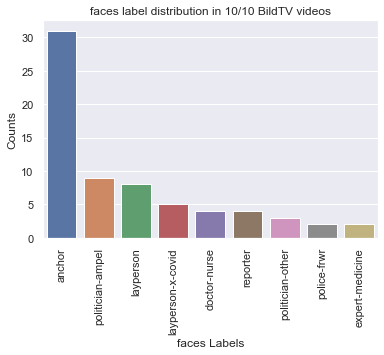

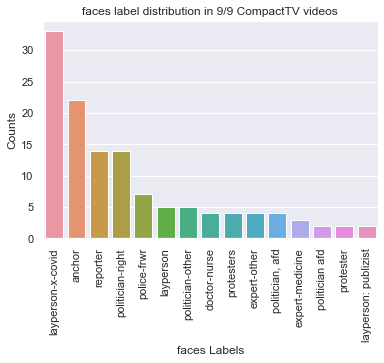

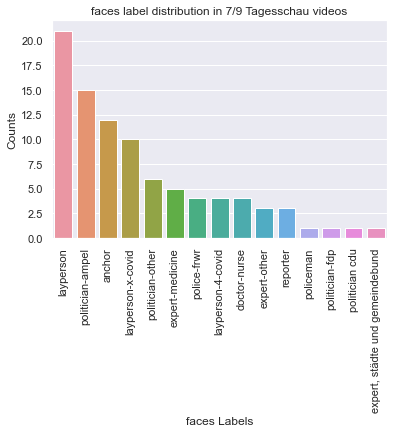

In [14]:
plot_annot_type("faces")

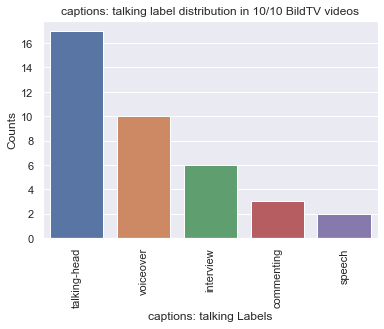

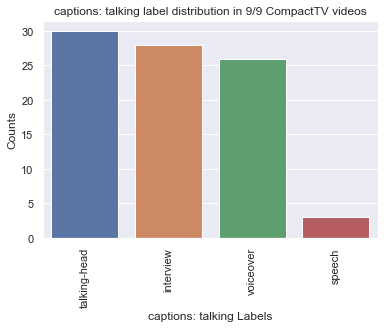

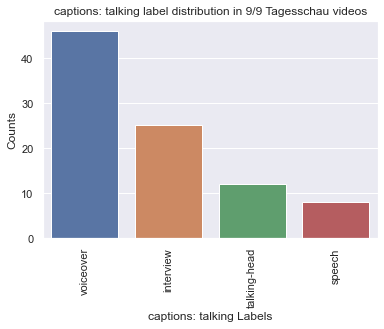

In [15]:
plot_annot_type("captions: talking")

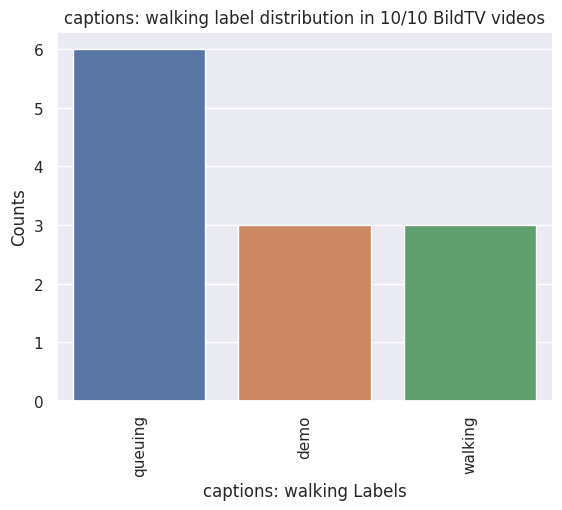

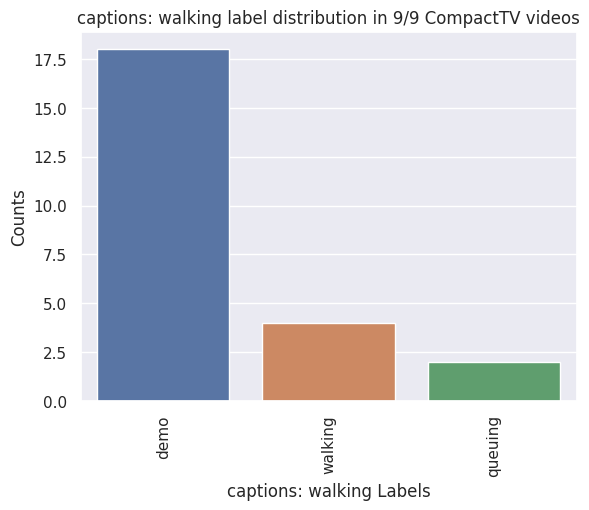

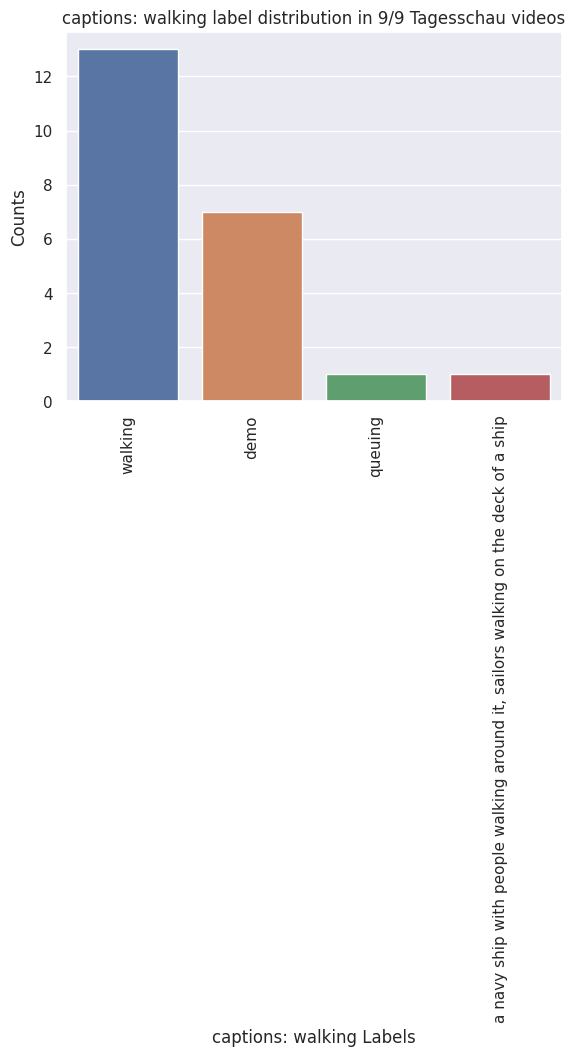

In [78]:
plot_annot_type("captions: walking")

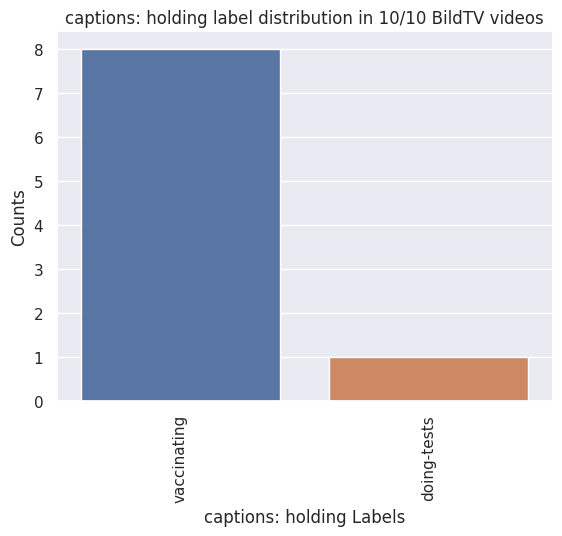

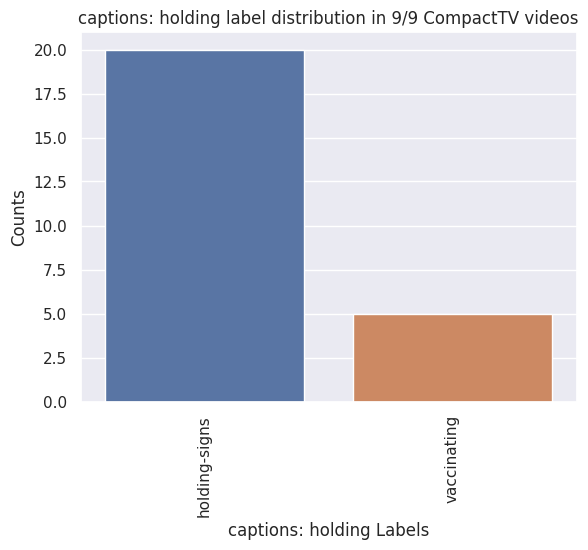

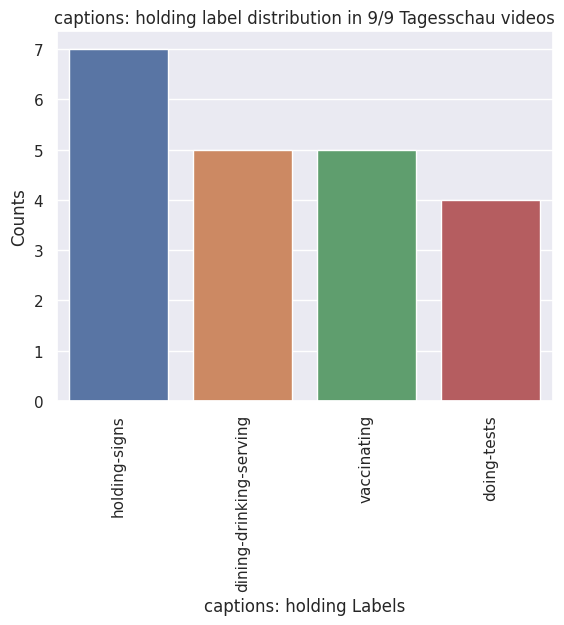

In [79]:
plot_annot_type("captions: holding")

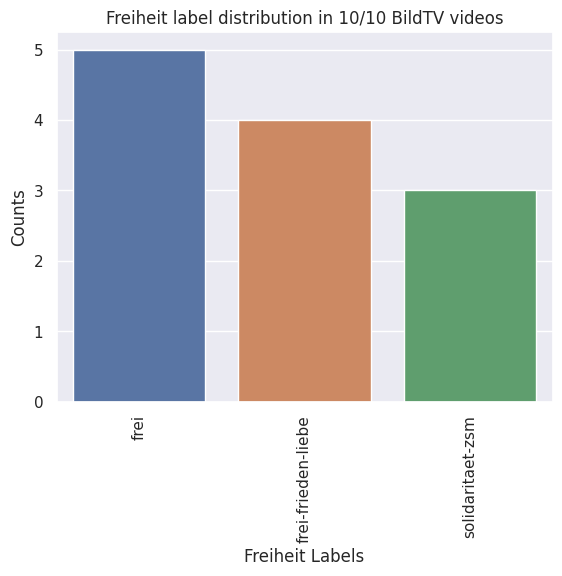

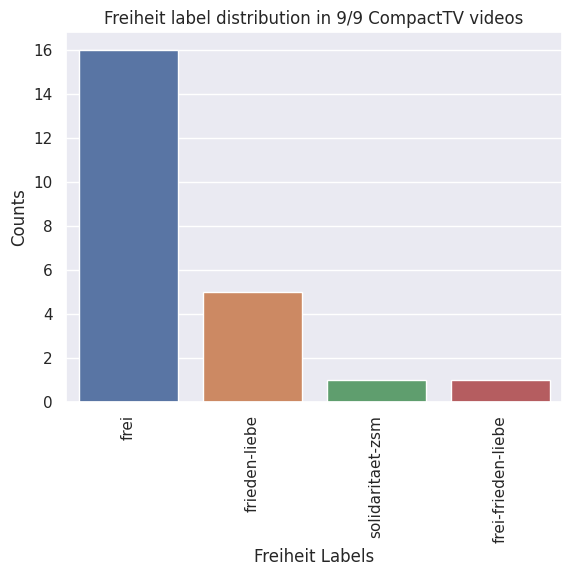

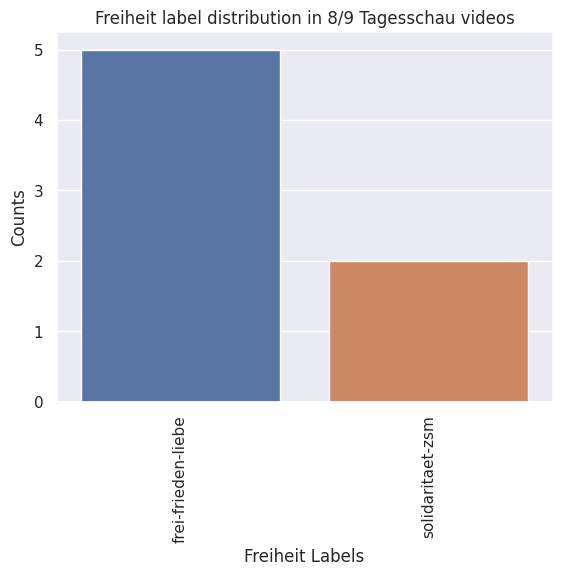

In [80]:
plot_annot_type("Freiheit")

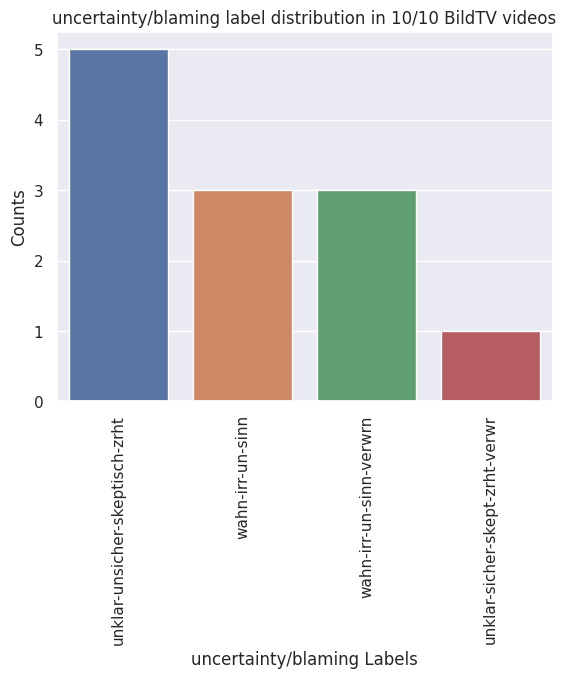

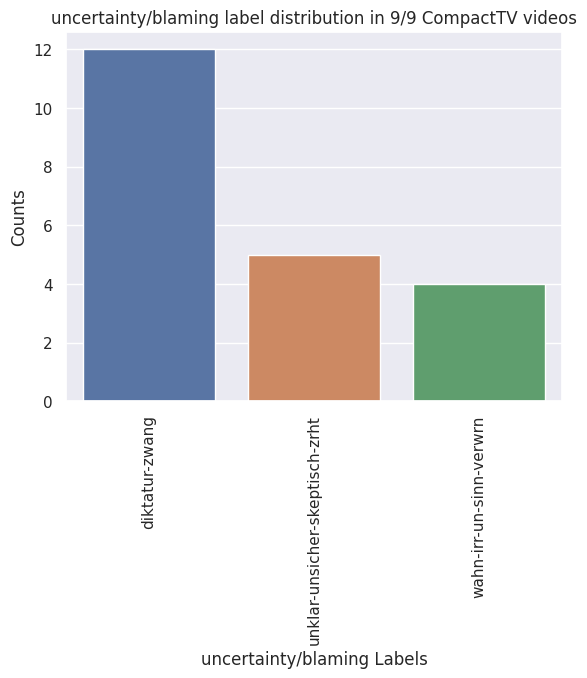

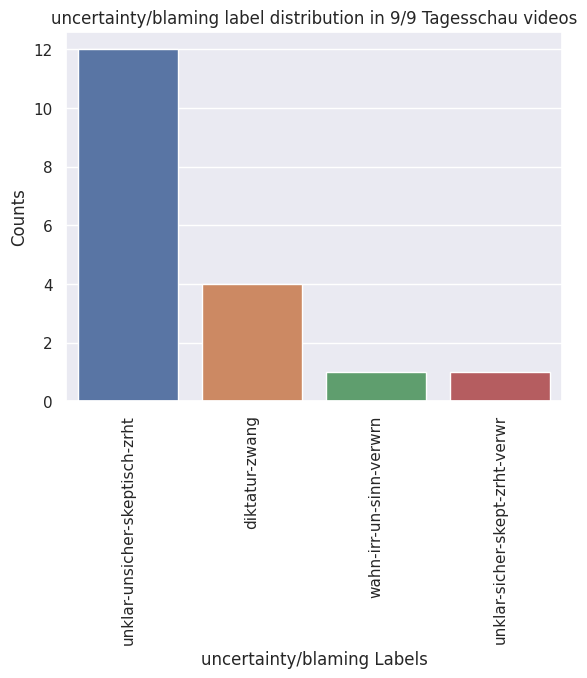

In [81]:
plot_annot_type("uncertainty/blaming")

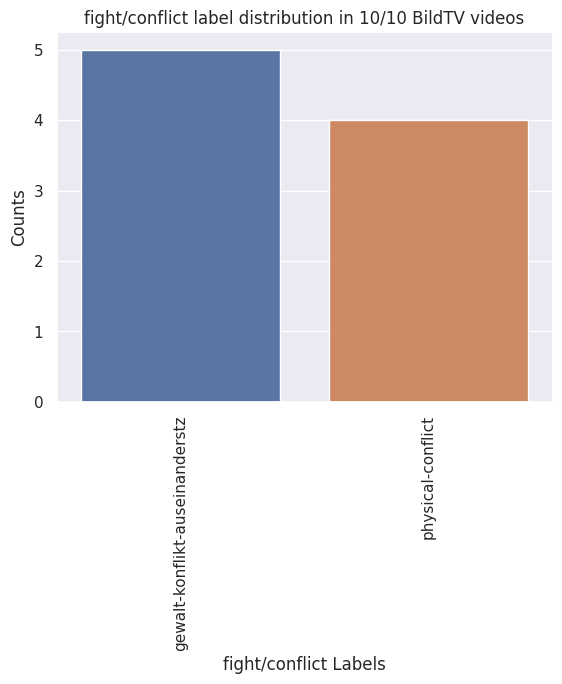

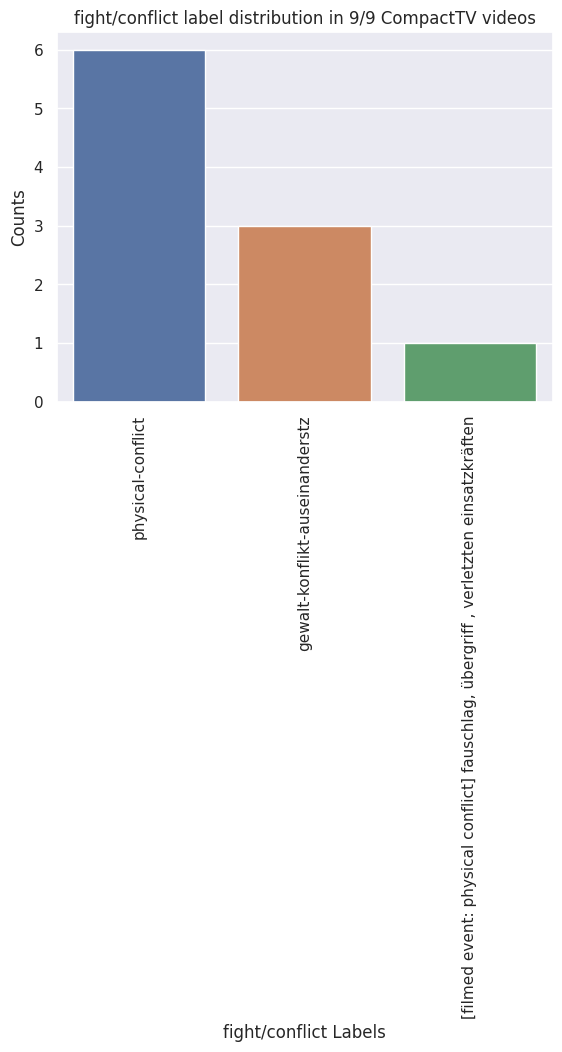

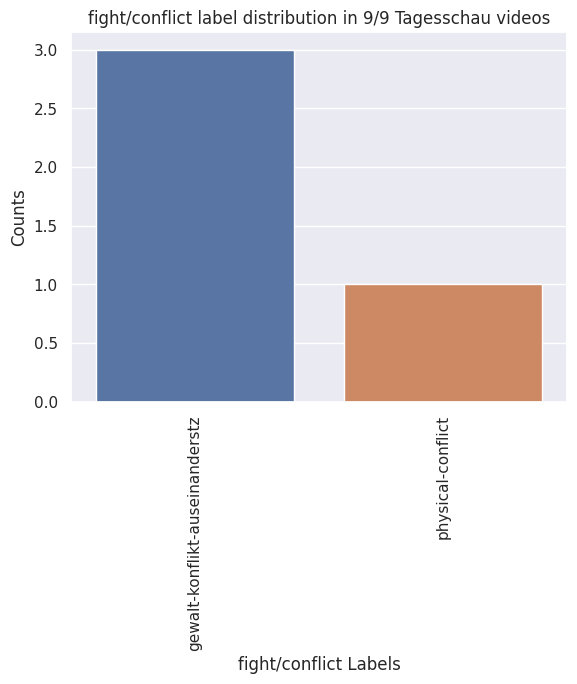

In [82]:
plot_annot_type("fight/conflict")

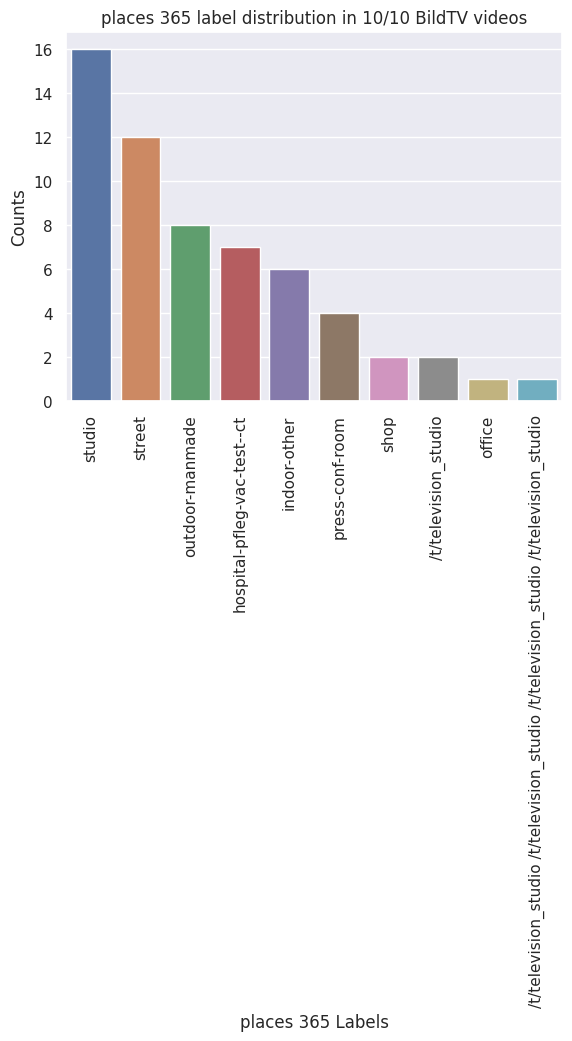

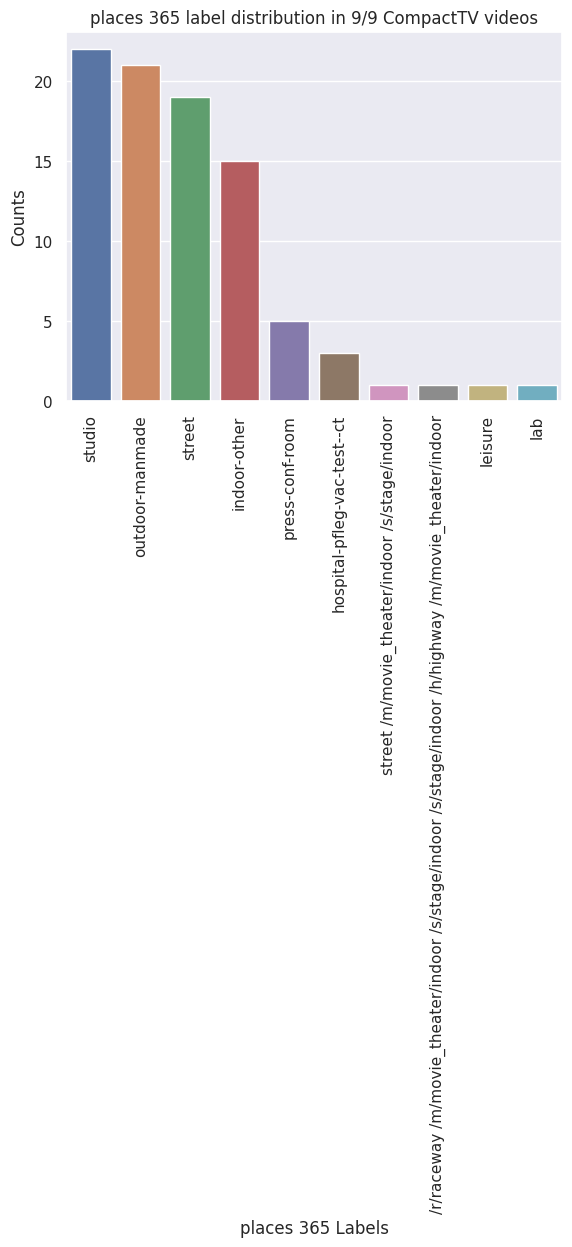

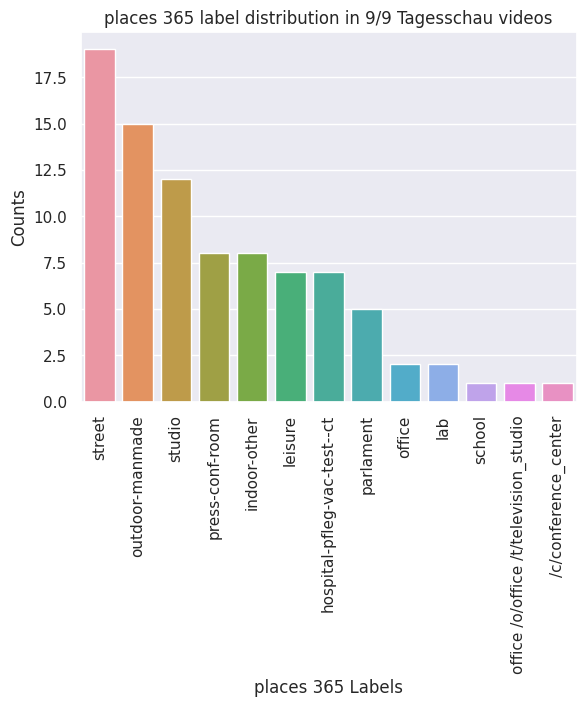

In [83]:
plot_annot_type("places 365")

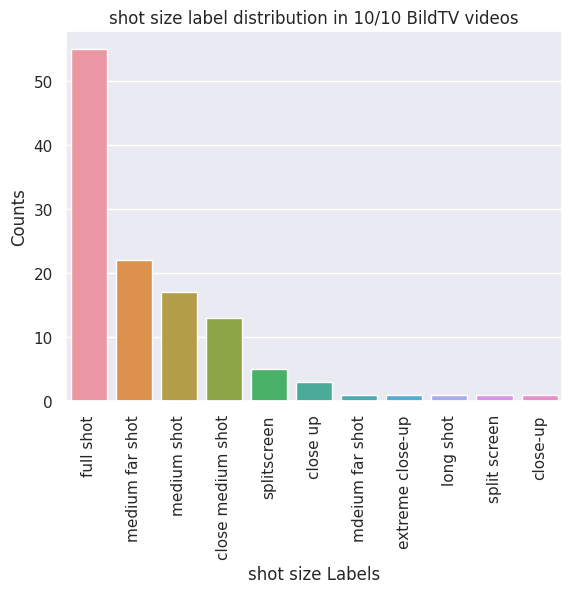

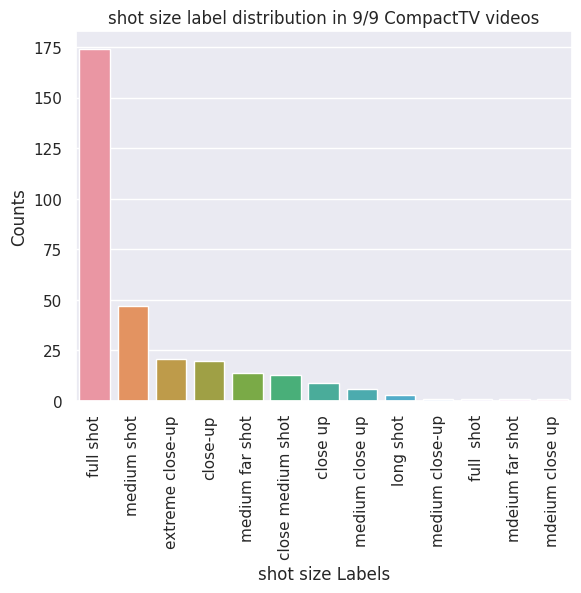

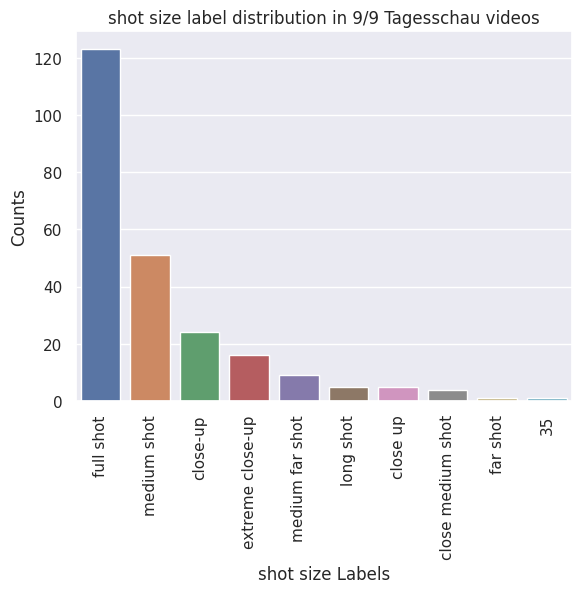

In [84]:
plot_annot_type("shot size")

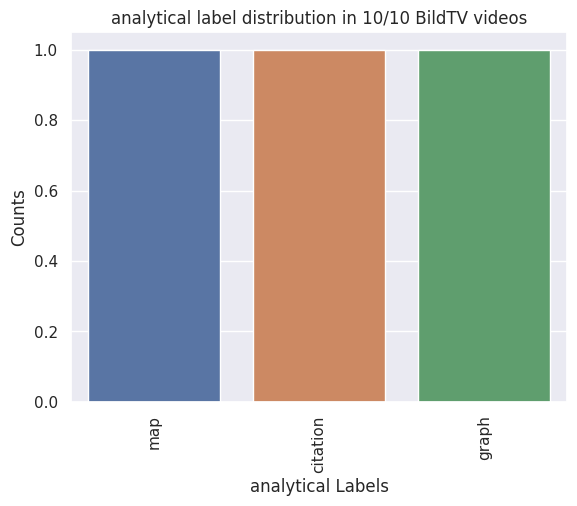

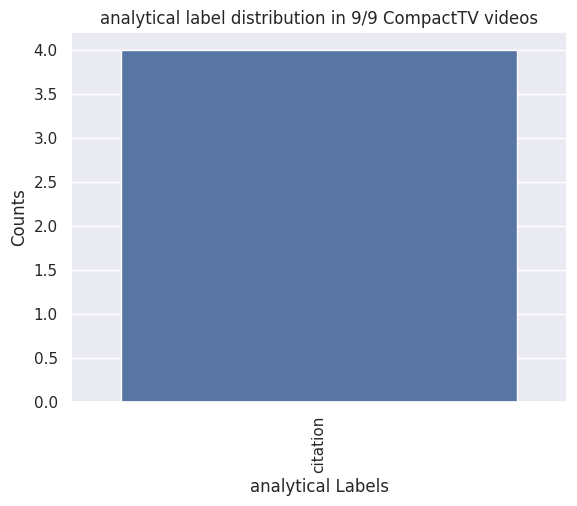

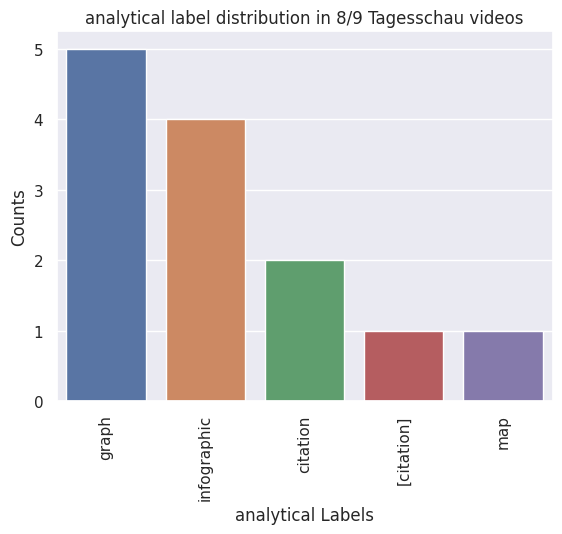

In [85]:
plot_annot_type("analytical")

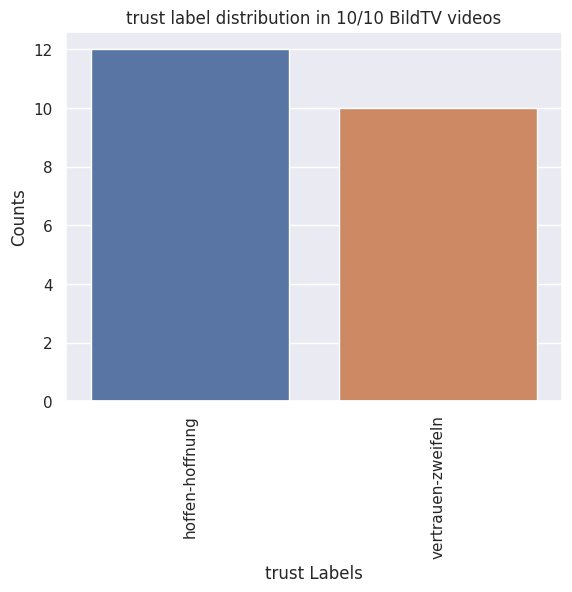

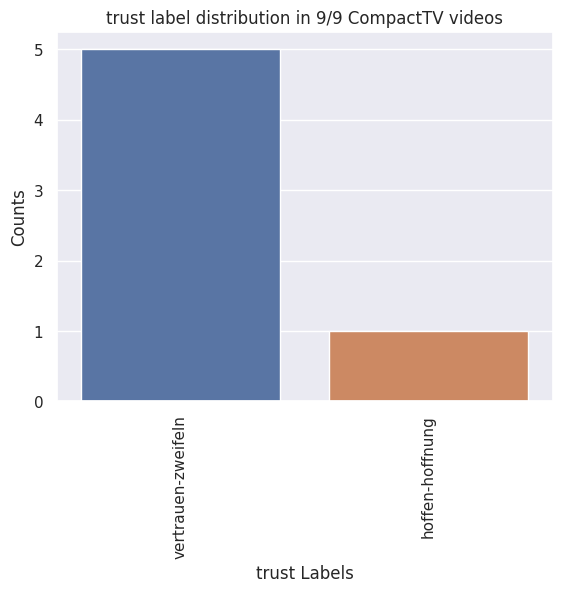

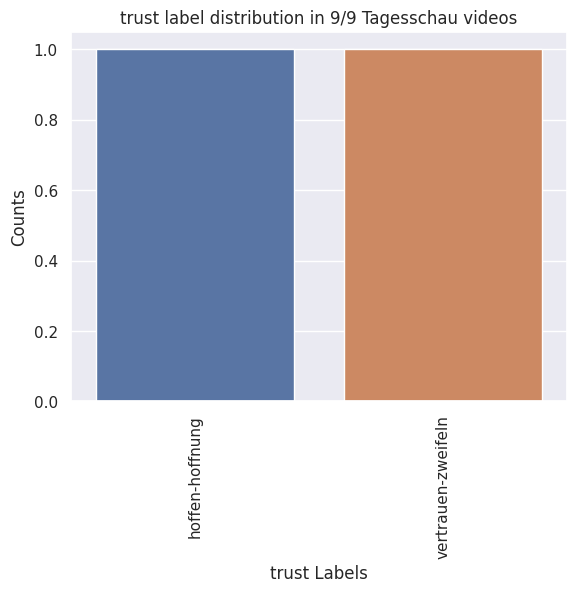

In [86]:
plot_annot_type("trust")

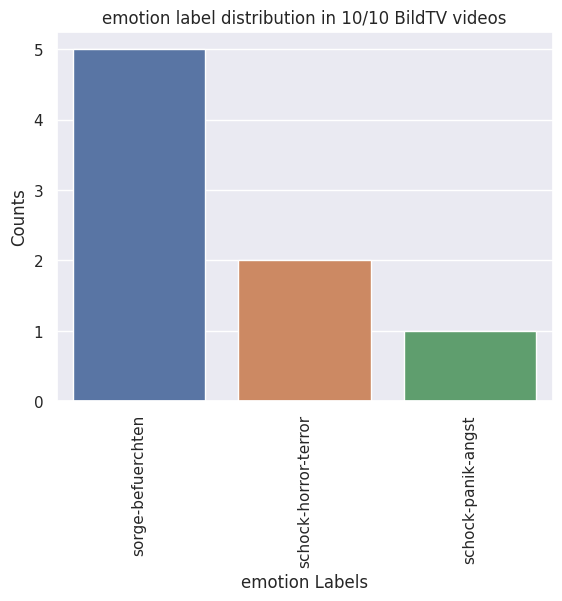

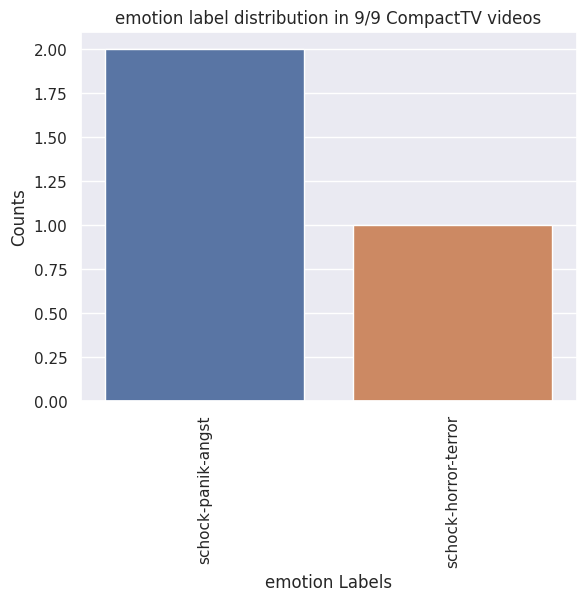

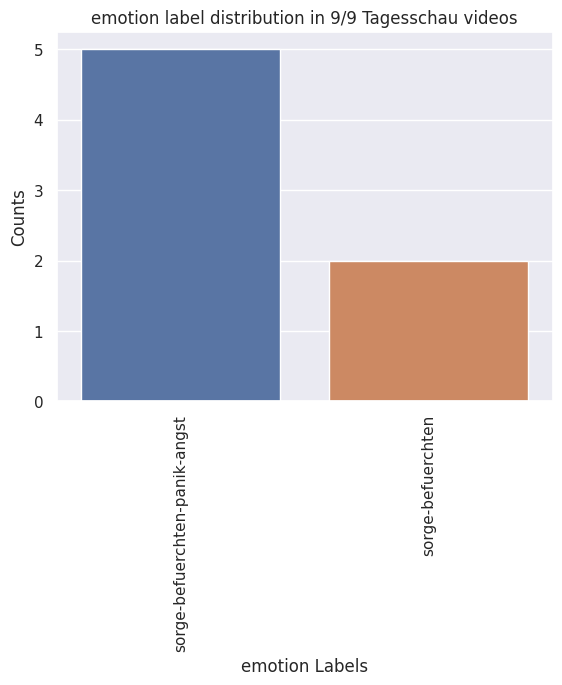

In [87]:
plot_annot_type("emotion")

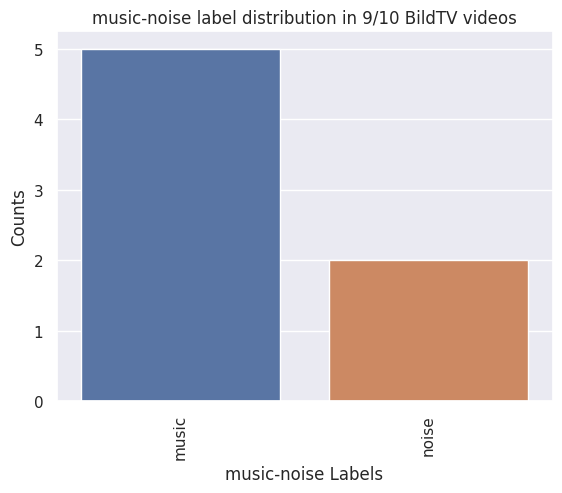

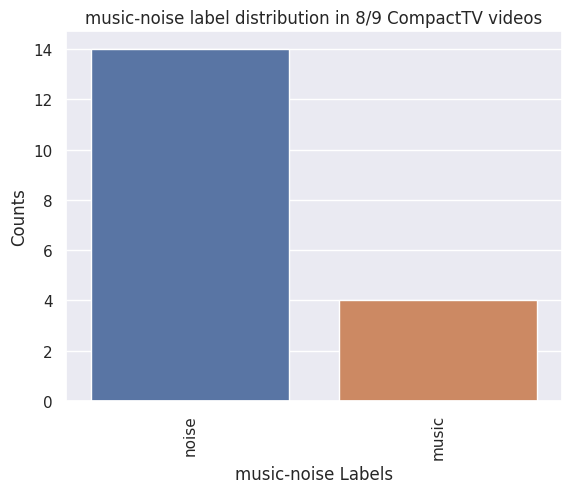

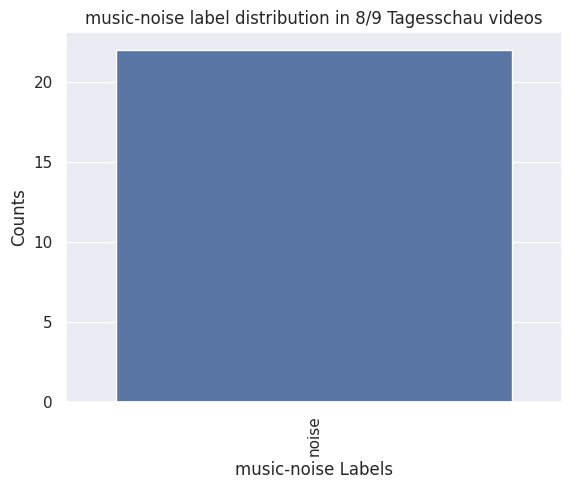

In [88]:
plot_annot_type("music-noise")